In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import os
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, autograd
import gluonnlp as nlp
from bert import *
from gluonnlp.data import TSVDataset
from glob import glob
from os.path import expanduser

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# seeding all randomizers
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(100)
random.seed(100)
mx.random.seed(100)

# use GPU when available otherwise use CPU
ctx = mx.gpu(0) if mx.test_utils.list_gpus() else mx.cpu()

In [2]:
dataset_name = '20ng'

In [3]:
nclasses = {"20ng":20, "imdb":2, "r8":8, "r52":52, "ohsumed_all": 23, "ohsumed_first": 23}

In [4]:
HOME = expanduser("~")
DATADIR = '{}/working_dir/classification/files/{}/'.format(HOME, dataset_name)
working_dir = "{}/working_dir/classification/models/bert/{}/".format(HOME, dataset_name)
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
filename = '{}/net.params'.format(working_dir)

In [5]:
# network params
# maximum sequence length
max_len = 150
# number of classes
n_classes = nclasses[dataset_name]
all_labels = [str(_) for _ in range(n_classes)]
# batch size
batch_size = 32
# initial learning rate
lr = 5e-6
# gradient clipping value
grad_clip = 1
# log to screen every 50 batch
log_interval = 50
# train until we fail to beat the current best validation loss for 5 consecutive epochs
max_patience = 5

In [6]:
def print_results(y_true, y_pred):
    print("Accuracy: {:0.3f}".format(accuracy_score(y_true, y_pred)))
    print("F1-Score: {:0.3f}".format(f1_score(y_true, y_pred, average="macro")))
    print("Precision: {:0.3f}".format(precision_score(y_true, y_pred, average="macro")))
    print("Recall: {:0.3f}".format(recall_score(y_true, y_pred, average="macro")))
    fig, ax = plt.subplots(figsize=(18, 10))
    x = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, ax=ax)
    x.invert_yaxis()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    return fig

class Dataset(TSVDataset):
    """Train dataset.

    Parameters
    ----------
    segment : str or list of str, default 'train'
        Dataset segment. Options are 'train', 'val', 'test' or their combinations.
    root : str, default 'dir containing train/dev/test datasets'
    """
    def __init__(self, segment='train', root='.', n_classes=2):
        self._supported_segments = ['train', 'dev', 'test']
        assert segment in self._supported_segments, 'Unsupported segment: %s'%segment
        path = os.path.join(root, '%s.tsv'%segment)
        A_IDX, LABEL_IDX = 0, 1
        fields = [A_IDX, LABEL_IDX]
        self.n_classes=n_classes
        super(Dataset, self).__init__(path, field_indices=fields)

    @staticmethod
    def get_labels():
        """Get classification label ids of the dataset."""
        return [str(_) for _ in range(self.n_classes)]

In [7]:
data_train = Dataset(root=DATADIR, segment='train', n_classes=n_classes)
data_dev = Dataset(root=DATADIR, segment='dev', n_classes=n_classes)
data_test = Dataset(root=DATADIR, segment='test', n_classes=n_classes)

In [8]:
sample_id = np.random.randint(0, len(data_train))
print('<<<<TEXT>>>>')
print(data_train[sample_id][0])
print("<<<<LABEL>>>>")
print(data_train[sample_id][1])

<<<<TEXT>>>>
from steph pegasus cs uiuc edu \\( dale stephenson \\) subject re rockies \\( not rookies \\) article i d pegasus steph 733996812 organization university of illinois , dept of comp sci , urbana , il lines 19 in c500u7 kr8 news cso uiuc edu dbl50872 uxa cso uiuc edu \\( daniel brian lake \\) writes you 'd think that an expansion team would be filled with young'ns , not guys like murphy , galaragga , b smith it depends if you can get your old veterans cheap , and if they can perform at a higher level than your young talent can now , why not the talent develop in the minors while giving the fans some familiar names to cheer if the veterans are gone in a year or two that should be just about right maybe someone should tell those renegade front office people in denver \\) open question which was more important to the expansion clubs , the expansion draft or the regular draft \\( they 've had one of each , i think \\) dale j stephenson \\( steph cs uiuc edu \\) baseball fanatic 

In [9]:
bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                             dataset_name='book_corpus_wiki_en_uncased',
                                             pretrained=True, ctx=ctx, use_pooler=True,
                                             use_decoder=False, use_classifier=False)
#print(bert_base)

In [10]:
# use the vocabulary from pre-trained model for tokenization
tokenizer = tokenization.FullTokenizer(vocabulary, do_lower_case=True)
transform = dataset.ClassificationTransform(tokenizer, all_labels, max_len, pair=False)

In [11]:
data_train = data_train.transform(transform)
data_dev = data_dev.transform(transform)
data_test = data_test.transform(transform)
print('token ids = \n%s'%data_train[sample_id][0])

token ids = 
[    2  2013  3357  2232 26606 20116 21318 14194  3968  2226  1032  1032
  1006  8512 19789  1032  1032  1007  3395  2128 22366  1032  1032  1006
  2025  8305  2015  1032  1032  1007  3720  1045  1040 26606  3357  2232
  6421 23499  2683  2575  2620 12521  3029  2118  1997  4307  1010 29466
  1997  4012  2361 16596  1010 27929  1010  6335  3210  2539  1999  1039
 29345  2226  2581  1047  2099  2620  2739 20116  2080 21318 14194  3968
  2226 16962  2140 12376  2620  2581  2475  1057 18684 20116  2080 21318
 14194  3968  2226  1032  1032  1006  3817  4422  2697  1032  1032  1007
  7009  2017  1005  1040  2228  2008  2019  4935  2136  2052  2022  3561
  2007  2402  1005 24978  1010  2025  4364  2066  7104  1010 16122 29181
  3654  1010  1038  3044  2009  9041  2065  2017  2064  2131  2115  2214
  8244 10036  1010  1998  2065  2027  2064  4685  2012  1037  3020  2504
  2084  2115  2402  5848  2064     3]


In [12]:
train_dataloader = mx.gluon.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, last_batch='rollover')
dev_dataloader = mx.gluon.data.DataLoader(data_dev, batch_size=batch_size, shuffle=False, last_batch='rollover')
test_dataloader = mx.gluon.data.DataLoader(data_dev, batch_size=batch_size, shuffle=False, last_batch='rollover')

In [13]:
model = bert.BERTClassifier(bert_base, num_classes=n_classes, dropout=0.1)
# only need to initialize the classifier layer.
model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
model.hybridize(static_alloc=True)

# softmax cross entropy loss for classification
loss_function = gluon.loss.SoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

metric = mx.metric.Accuracy()

In [14]:
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr, 'epsilon': 1e-9})

# collect all differentiable parameters
# grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
# the gradients for these params are clipped later
params = [p for p in model.collect_params().values() if p.grad_req != 'null']

train_step = 0
epoch_id = 0
best_loss = None
patience = 0
while True:
    metric.reset()
    step_loss = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
        # load data to GPU
        token_ids = token_ids.as_in_context(ctx)
        valid_length = valid_length.as_in_context(ctx)
        segment_ids = segment_ids.as_in_context(ctx)
        label = label.as_in_context(ctx)

        with autograd.record():
            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

        # backward computation
        ls.backward()

        # gradient clipping
        grads = [p.grad(c) for p in params for c in [ctx]]
        gluon.utils.clip_global_norm(grads, grad_clip)

        # parameter update
        trainer.step(1)
        step_loss += ls.asscalar()
        metric.update([label], [out])
        if (batch_id + 1) % (log_interval) == 0:
            print('[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f}'
                         .format(epoch_id, batch_id + 1, len(train_dataloader),
                                 step_loss / log_interval,
                                 trainer.learning_rate, metric.get()[1]))
            step_loss = 0
        train_step +=1
    epoch_id+=1
    ########################
    #### RUN EVALUATION ####
    ########################
    dev_loss = []
    y_true = []
    y_pred = []
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(dev_dataloader):
        # load data to GPU
        token_ids = token_ids.as_in_context(ctx)
        valid_length = valid_length.as_in_context(ctx)
        segment_ids = segment_ids.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # get logits and loss value
        out = model(token_ids, segment_ids, valid_length.astype('float32'))
        ls = loss_function(out, label).mean()
        dev_loss.append(ls.asscalar())
        probs = out.softmax()
        pred = nd.argmax(probs, axis=1).asnumpy()
        y_true.extend(list(np.reshape(label.asnumpy(), (-1))))
        y_pred.extend(pred)
    dev_loss = np.mean(dev_loss)
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    print('EVALUATION ON DEV DATASET:')
    print('dev mean loss: {:.4f}, f1-score: {:.4f}, accuracy: {:0.4f}'.format(dev_loss, f1, acc))
    if best_loss is None or dev_loss < best_loss:
        model.save_parameters('{}_best'.format(filename, train_step))
        best_loss = dev_loss
        patience=0
    else:
        new_lr = trainer.learning_rate/2
        trainer.set_learning_rate(new_lr)
        print('patience #{}: reducing the lr to {}'.format(patience, new_lr))
        patience+=1
    if patience == max_patience:
        model.save_parameters('{}_{}'.format(filename, train_step))
        break

[Epoch 0 Batch 50/300] loss=3.0178, lr=0.0000050, acc=0.056
[Epoch 0 Batch 100/300] loss=2.9149, lr=0.0000050, acc=0.088
[Epoch 0 Batch 150/300] loss=2.6667, lr=0.0000050, acc=0.150
[Epoch 0 Batch 200/300] loss=2.4379, lr=0.0000050, acc=0.205
[Epoch 0 Batch 250/300] loss=2.2472, lr=0.0000050, acc=0.256
[Epoch 0 Batch 300/300] loss=2.0707, lr=0.0000050, acc=0.302
EVALUATION ON DEV DATASET:
dev mean loss: 1.9840, f1-score: 0.4830, accuracy: 0.5336
[Epoch 1 Batch 50/300] loss=1.9188, lr=0.0000050, acc=0.578
[Epoch 1 Batch 100/300] loss=1.7727, lr=0.0000050, acc=0.590
[Epoch 1 Batch 150/300] loss=1.6514, lr=0.0000050, acc=0.602
[Epoch 1 Batch 200/300] loss=1.5138, lr=0.0000050, acc=0.620
[Epoch 1 Batch 250/300] loss=1.4171, lr=0.0000050, acc=0.632
[Epoch 1 Batch 300/300] loss=1.3687, lr=0.0000050, acc=0.640
EVALUATION ON DEV DATASET:
dev mean loss: 1.2783, f1-score: 0.6638, accuracy: 0.6916
[Epoch 2 Batch 50/300] loss=1.2419, lr=0.0000050, acc=0.721
[Epoch 2 Batch 100/300] loss=1.1763, lr=

In [15]:
# load the best pre-trained model for evaluation
best_ckpt = glob('{}*best'.format(filename))[0]
model = bert.BERTClassifier(bert_base, num_classes=n_classes, dropout=0.1)
model.load_parameters(best_ckpt, ctx=ctx)

In [16]:
y_true = []
y_pred = []
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.as_in_context(ctx)
    valid_length = valid_length.as_in_context(ctx)
    segment_ids = segment_ids.as_in_context(ctx)
    label = label.as_in_context(ctx)
    out = model(token_ids, segment_ids, valid_length.astype('float32')).softmax()
    pred = nd.argmax(out, axis=1).asnumpy()
    y_true.extend(list(np.reshape(label.asnumpy(), (-1))))
    y_pred.extend(pred)
assert len(y_true)==len(y_pred)

Accuracy: 0.910
F1-Score: 0.912
Precision: 0.915
Recall: 0.911


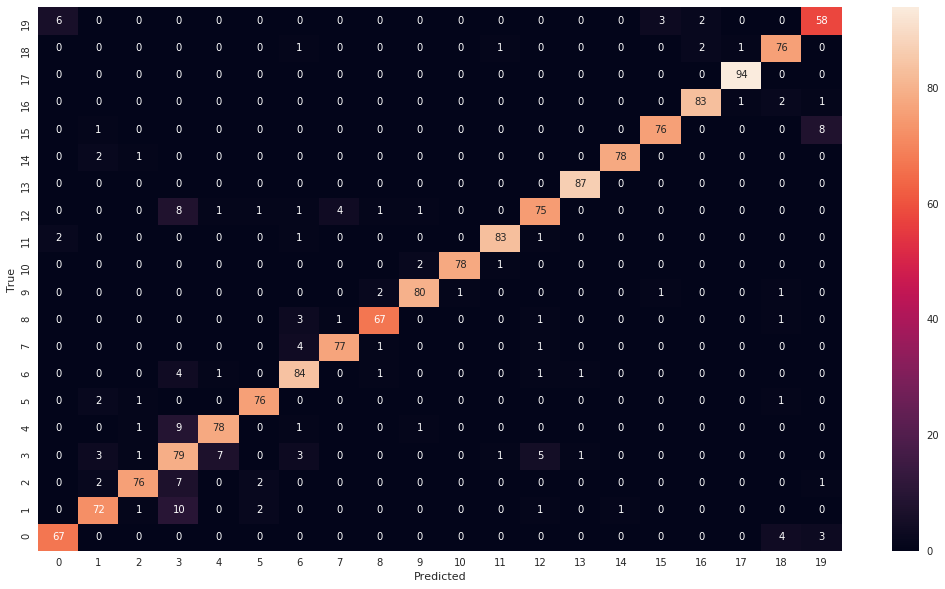

In [17]:
fig = print_results(np.reshape(y_true, (-1)), y_pred)
fig.savefig('{}/cm.png'.format(working_dir))